In [1]:
#Liste des import
import os
import numpy as np
import pandas as pd
import torch
import torch.utils.data as Data
import torch.nn as nn
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt



In [19]:
#Création du dataset avec biais
class BiasedDataset(Data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None,test=False,p0=0,p1=1,sigma=1):
        self.test=test
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels['label']=self.img_labels['label']
        self.img_dir = img_dir
        self.img_files=os.listdir(img_dir)
        self.transform = transforms.Compose([ #Transformation à effectuer
            transforms.ToPILImage(),
            transforms.CenterCrop(size=256),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(0.5,0.5),
        ])
        self.target_transform = target_transform

        self.p0=p0 #Proba p0,p1 et sigma
        self.p1=p1
        self.sigma = sigma

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        if not self.test:
            img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])+'.jpg')
            image = read_image(img_path)

            label = self.img_labels.iloc[idx, 1]-1
            #On modifie les labels 0,2 -> 0 et 1,3 -> 1 : Chou/chou-fleurs contre le reste
            if label==0 or label==2:
                label=0
            else:
                label=1  

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)

            epsilon = torch.zeros_like(image)
            if label==0: #proba de bernoulli défini selon le label de l'image
                proba=self.p0
            else:
                proba =self.p1
                
            S=torch.bernoulli(torch.tensor([proba],dtype=torch.float))
            if S.item() == 1: #si on tire 1, le bruit est gaussien et non plus égale à zero
                epsilon = torch.normal(0, self.sigma, size=image.size())
                
            biased_image = torch.cat((image, epsilon), dim=0)
            return biased_image, label
        

        else:
            #Exactement comme dans l'autre if, sauf que l'indice change pour lire l'image
            img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]+3492)+'.jpg')
            image = read_image(img_path)

            label = self.img_labels.iloc[idx+3492, 1]-1
            if label==0 or label==2:
                label=0
            else:
                label=1

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)

            epsilon = torch.zeros_like(image)
            if label==0:
                proba=self.p0
            else:
                proba =self.p1


            S=torch.bernoulli(torch.tensor([proba],dtype=torch.float))
            if S == 1:
                epsilon = torch.normal(0, self.sigma, size=image.size())
                
            biased_image = torch.cat((image, epsilon), dim=0)
            return biased_image, label,S



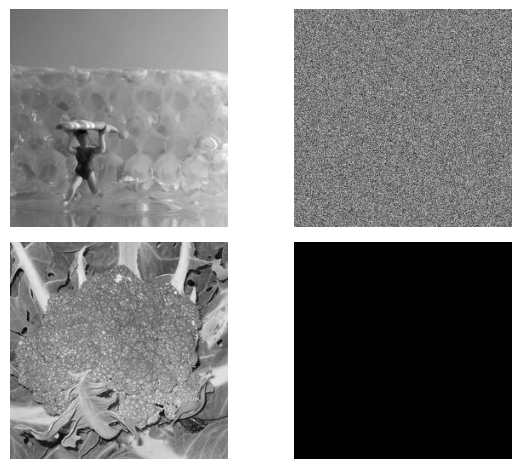

In [20]:
df=BiasedDataset("train.csv","train/train")

# On affiche 2 images, une de label 0 et une de 1, avec leur bruit

plt.subplot(2, 2, 1)
plt.imshow(df.__getitem__(0)[0][0],cmap='gray')  
plt.axis('off')  

plt.subplot(2, 2, 2)
plt.imshow(df.__getitem__(0)[0][1],cmap='gray')  
plt.axis('off')  

plt.subplot(2, 2, 3)
plt.imshow(df.__getitem__(1)[0][0],cmap='gray')  
plt.axis('off')  

plt.subplot(2, 2, 4)
plt.imshow(df.__getitem__(1)[0][1],cmap='gray')  
plt.axis('off')  

plt.tight_layout()
plt.show()

In [35]:
# On recrée un alexNet, similaire à celui de l'autre notebook, sauf que celui ci prend 2 canaux en entrée
class AlexNetBiased(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetBiased, self).__init__()
        self.network = nn.Sequential(

            nn.Conv2d(2, 96, kernel_size=11, stride=4), #On mets 2 canaux en entrée ici
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Flatten(),

            nn.Linear(256 * 6 *6, 4096),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(4096, 4096),
            nn.Dropout(0.5),

            nn.ReLU(),
            
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [22]:
#On crée les jeux de train et de test 
train_dataset=BiasedDataset("train.csv","biased/train")
test_dataset=BiasedDataset("train.csv","biased/test",p0=0.5,p1=0.5,test=True)


trainloader = Data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = Data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Epoch 1/10: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Accuracy de train : 0.5083046964490263
Accuracy de test : 0.49786324786324787
Loss de train : 0.7140143939426967
Loss de test : 0.6938488632440567


Epoch 2/10: 100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Accuracy de train : 0.6463344788087056
Accuracy de test : 0.5192307692307693
Loss de train : 0.64510706279959
Loss de test : 0.7027470469474792


Epoch 3/10: 100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Accuracy de train : 0.7563001145475372
Accuracy de test : 0.5064102564102564
Loss de train : 0.5930327666657311
Loss de test : 0.7212654948234558


Epoch 4/10: 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Accuracy de train : 0.8224513172966781
Accuracy de test : 0.5064102564102564
Loss de train : 0.5475584673030036
Loss de test : 0.7468700706958771


Epoch 5/10: 100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Accuracy de train : 0.8843069873997709
Accuracy de test : 0.5128205128205128
Loss de train : 0.5032891130873135
Loss de test : 0.7526045739650726


Epoch 6/10: 100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Accuracy de train : 0.9286941580756014
Accuracy de test : 0.5277777777777778
Loss de train : 0.46770361598048893
Loss de test : 0.7647784501314163


Epoch 7/10: 100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Accuracy de train : 0.9558991981672395
Accuracy de test : 0.47649572649572647
Loss de train : 0.431665521647249
Loss de test : 0.8328830599784851


Epoch 8/10: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Accuracy de train : 0.9733676975945017
Accuracy de test : 0.5
Loss de train : 0.40366638877562117
Loss de test : 0.8214862942695618


Epoch 9/10: 100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Accuracy de train : 0.986540664375716
Accuracy de test : 0.47863247863247865
Loss de train : 0.3732232547232083
Loss de test : 0.8609315454959869


Epoch 10/10: 100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Accuracy de train : 0.9928407789232532
Accuracy de test : 0.5128205128205128
Loss de train : 0.3475120280470167
Loss de test : 0.8650621622800827
Entraînement terminé


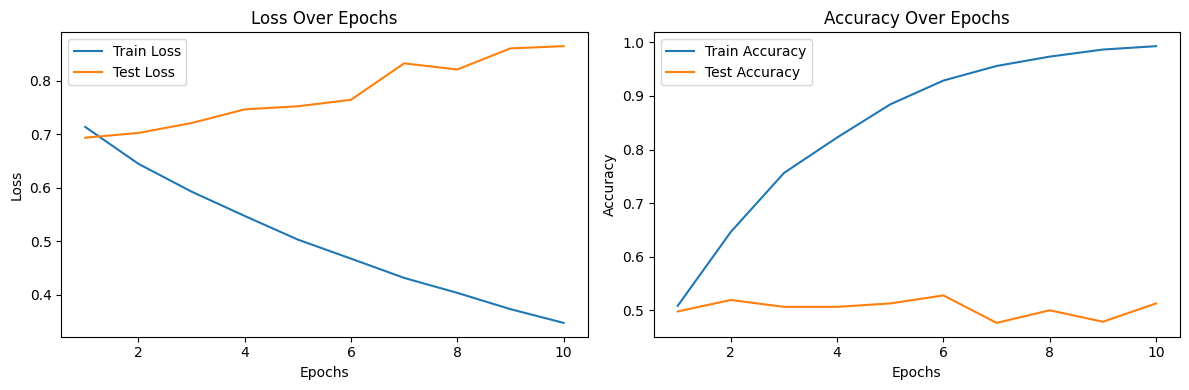

Accuracy finale : 0.5128205128205128


In [23]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score


device = torch.device('cuda')

num_epochs = 10
model = AlexNetBiased(num_classes=2)
model.to(device)

#On fait un apprentissage avec un pas très petit pour visualiser correctement le phénomène
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7) #lr très petit pour visualisation

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        #Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label,_ = batch
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")
    print(f"Accuracy de test : {test_accuracies[-1]}")

    print(f"Loss de train : {train_losses[-1]}")
    print(f"Loss de test : {test_losses[-1]}")
print('Entraînement terminé')


#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {test_accuracies[-1]}")

Epoch 1/10: 100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Accuracy de train : 0.961340206185567
Accuracy de test : 0.5235042735042735
Loss de train : 0.06937544645435446
Loss de test : 11.627227306365967


Epoch 2/10: 100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Accuracy de train : 1.0
Accuracy de test : 0.4658119658119658
Loss de train : 2.0775112010072506e-07
Loss de test : 19.057072401046753


Epoch 3/10: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Accuracy de train : 1.0
Accuracy de test : 0.5064102564102564
Loss de train : 8.103608992171552e-08
Loss de test : 18.248528718948364


Epoch 4/10: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Accuracy de train : 1.0
Accuracy de test : 0.4935897435897436
Loss de train : 6.537358491844256e-08
Loss de test : 18.587943077087402


Epoch 5/10: 100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Accuracy de train : 1.0
Accuracy de test : 0.46794871794871795
Loss de train : 6.672256652739961e-08
Loss de test : 19.807031631469727


Epoch 6/10: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Accuracy de train : 1.0
Accuracy de test : 0.5
Loss de train : 4.590456916372546e-08
Loss de test : 18.252890586853027


Epoch 7/10: 100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Accuracy de train : 1.0
Accuracy de test : 0.5256410256410257
Loss de train : 7.640150670253285e-08
Loss de test : 16.904990434646606


Epoch 8/10: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Accuracy de train : 1.0
Accuracy de test : 0.4594017094017094
Loss de train : 3.486915026361194e-08
Loss de test : 20.11484432220459


Epoch 9/10: 100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Accuracy de train : 1.0
Accuracy de test : 0.48504273504273504
Loss de train : 2.5230704700110858e-08
Loss de test : 19.037324905395508


Epoch 10/10: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Accuracy de train : 1.0
Accuracy de test : 0.4893162393162393
Loss de train : 1.872622964828517e-08
Loss de test : 19.43764019012451
Entraînement terminé


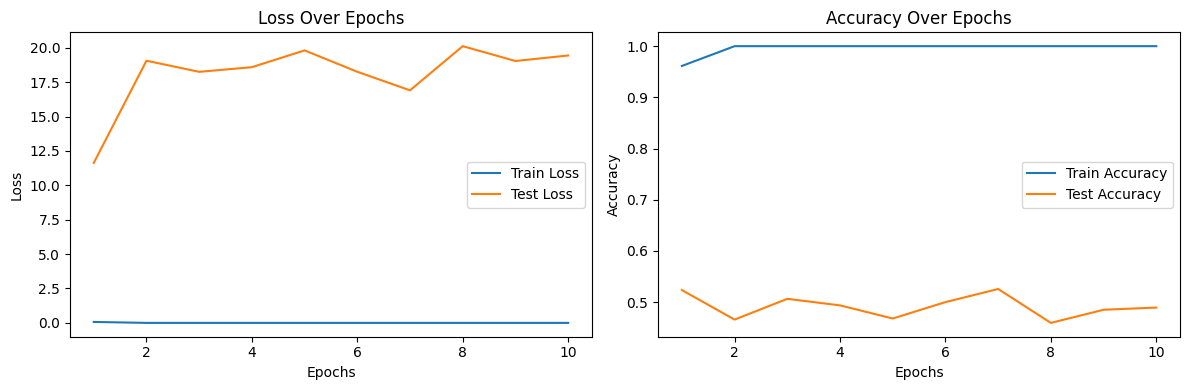

Accuracy finale : 0.4893162393162393


In [24]:
num_epochs = 10
model = AlexNetBiased(num_classes=2)
model.to(device)

#On refait l'apprentissage avec un pas permettant une convergence rapide
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        #Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label,_ = batch
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")
    print(f"Accuracy de test : {test_accuracies[-1]}")

    print(f"Loss de train : {train_losses[-1]}")
    print(f"Loss de test : {test_losses[-1]}")
print('Entraînement terminé')


#Affichage des résultats 
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {test_accuracies[-1]}")
torch.save(model.state_dict(), 'Alex_Net_biased.pth')

Epoch 1/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.5833333333333334
Accuracy de test : 0.6003937007874016
Loss de train : 0.685806365949767
Loss de test : 0.6510350406169891


Epoch 2/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.6420389461626576
Accuracy de test : 0.6358267716535433
Loss de train : 0.64044603066785
Loss de test : 0.6400406211614609


Epoch 3/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.6640893470790378
Accuracy de test : 0.6456692913385826
Loss de train : 0.6164660943405968
Loss de test : 0.6188855171203613


Epoch 4/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.6970217640320733
Accuracy de test : 0.6988188976377953
Loss de train : 0.5743134543299675
Loss de test : 0.6192061603069305


Epoch 5/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.7130584192439863
Accuracy de test : 0.6791338582677166
Loss de train : 0.5650154969521931
Loss de test : 0.5832191705703735


Epoch 6/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.711340206185567
Accuracy de test : 0.6988188976377953
Loss de train : 0.5667873142021043
Loss de test : 0.5735012292861938


Epoch 7/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.7164948453608248
Accuracy de test : 0.6791338582677166
Loss de train : 0.5536864187036242
Loss de test : 0.5805793404579163


Epoch 8/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.7282359679266895
Accuracy de test : 0.687007874015748
Loss de train : 0.5390962862542698
Loss de test : 0.5872864723205566


Epoch 9/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.736540664375716
Accuracy de test : 0.6771653543307087
Loss de train : 0.5347096802932876
Loss de test : 0.5901823341846466


Epoch 10/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.7508591065292096
Accuracy de test : 0.7263779527559056
Loss de train : 0.5107059766139302
Loss de test : 0.5571860000491142


Epoch 11/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.7600229095074456
Accuracy de test : 0.7519685039370079
Loss de train : 0.498794609946864
Loss de test : 0.5356405377388


Epoch 12/15: 100%|██████████| 28/28 [01:08<00:00,  2.44s/it]


Accuracy de train : 0.7565864833906071
Accuracy de test : 0.7381889763779528
Loss de train : 0.4988025033048221
Loss de test : 0.5265021175146103


Epoch 13/15: 100%|██████████| 28/28 [01:08<00:00,  2.44s/it]


Accuracy de train : 0.7809278350515464
Accuracy de test : 0.7007874015748031
Loss de train : 0.46697133779525757
Loss de test : 0.5992284715175629


Epoch 14/15: 100%|██████████| 28/28 [01:08<00:00,  2.45s/it]


Accuracy de train : 0.77290950744559
Accuracy de test : 0.639763779527559
Loss de train : 0.471167480306966
Loss de test : 0.7403532117605209


Epoch 15/15: 100%|██████████| 28/28 [01:08<00:00,  2.44s/it]


Accuracy de train : 0.7714776632302406
Accuracy de test : 0.6929133858267716
Loss de train : 0.47287010720797945
Loss de test : 0.7047874182462692
Entraînement terminé


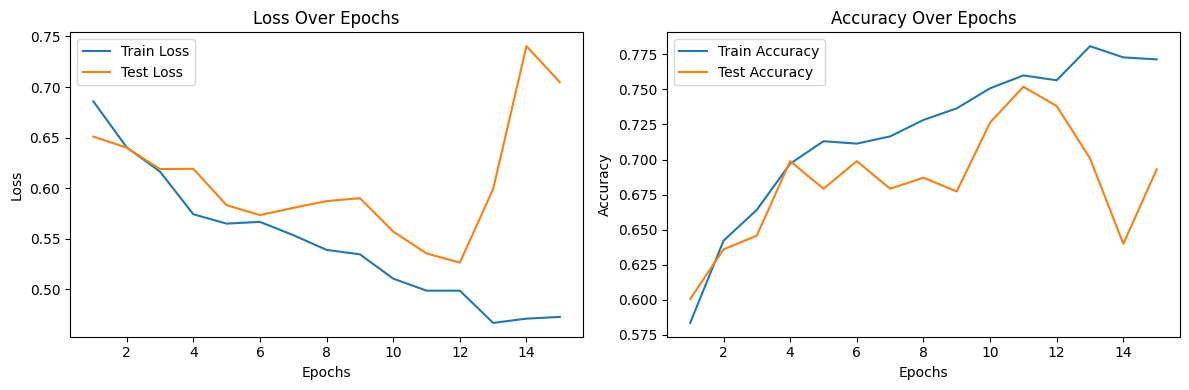

Accuracy finale : 0.6929133858267716


In [37]:
#On refait un apprentissage en mettant p0 et p1 à 0.5 pendnant l'entrainement aussi

#Définition des datasets de test et de train
df_less_biased=BiasedDataset("train.csv","train/train",p0=0.5,p1=0.5)
train_size = 3492
test_size = len(df_less_biased) - train_size
train_dataset =Data.Subset(df_less_biased, range(train_size))
test_dataset = Data.Subset(df_less_biased, range(train_size, train_size + test_size))

trainloader = Data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = Data.DataLoader(test_dataset, batch_size=128, shuffle=False)

num_epochs = 15
model = AlexNetBiased(num_classes=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5,weight_decay=1e-2)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)

        running_loss += loss.item()
        # Calcul de l'accuracy  
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()

    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label= batch
            inputs, label = inputs.to(device).float(), label.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")
    print(f"Accuracy de test : {test_accuracies[-1]}")

    print(f"Loss de train : {train_losses[-1]}")
    print(f"Loss de test : {test_losses[-1]}")
print('Entraînement terminé')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {test_accuracies[-1]}")
torch.save(model.state_dict(), 'Alex_Net_less_biased.pth')

In [10]:
# Classe pour les datasets non biaisés, similaire à celle de l'autre notebook, avec des transformation en moins et seulement 2 classes
class ImageDataset(Data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None,test=False):
        self.test=test
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.img_files=os.listdir(img_dir)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop(size=256),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(0.5,0.5),
        ])
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        if not self.test:
            img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])+'.jpg')
            image = read_image(img_path)
            label = self.img_labels.iloc[idx, 1]-1

            #On modifie les labels 0,2 -> 0 et 1,3 -> 1 : Chou/chou-fleurs contre le reste
            if label==0 or label==2:
                label=0
            else:
                label=1

            if self.transform:
                image = self.transform(image)

            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else:
            img_path = os.path.join(self.img_dir, f'{4000 + idx}.jpg')
            image = read_image(img_path)
            if self.transform:
                image = self.transform(image)
            return image



In [11]:
# Classe équivalente à l'AlexNet classique de l'autre notebook
class AlexNetUnbiased(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetUnbiased, self).__init__()
        self.network = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding='same'),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Flatten(),

            nn.Linear(256 * 6 *6, 4096),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(4096, 4096),
            nn.Dropout(0.5),

            nn.ReLU(),
            
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [20]:
train_size = 3492
test_size = len(df) - train_size

df=ImageDataset("train.csv","train/train")

#On crée les dataset de train et de test 
train_dataset =Data.Subset(df, range(train_size))
test_dataset = Data.Subset(df, range(train_size, train_size + test_size))

trainloader = Data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = Data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Epoch 1/25: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Accuracy de train : 0.5332187857961054
Accuracy de test : 0.5216535433070866


Epoch 2/25: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Accuracy de train : 0.6191294387170676
Accuracy de test : 0.6259842519685039


Epoch 3/25: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Accuracy de train : 0.6417525773195877
Accuracy de test : 0.6732283464566929


Epoch 4/25: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Accuracy de train : 0.6798396334478809
Accuracy de test : 0.6712598425196851


Epoch 5/25: 100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Accuracy de train : 0.6973081328751431
Accuracy de test : 0.6968503937007874


Epoch 6/25: 100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Accuracy de train : 0.7230813287514318
Accuracy de test : 0.6948818897637795


Epoch 7/25: 100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Accuracy de train : 0.7336769759450171
Accuracy de test : 0.7007874015748031


Epoch 8/25: 100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Accuracy de train : 0.7479954180985109
Accuracy de test : 0.7165354330708661


Epoch 9/25: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Accuracy de train : 0.7663230240549829
Accuracy de test : 0.7165354330708661


Epoch 10/25: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Accuracy de train : 0.7749140893470791
Accuracy de test : 0.7381889763779528


Epoch 11/25: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Accuracy de train : 0.7918098510882016
Accuracy de test : 0.7421259842519685


Epoch 12/25: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Accuracy de train : 0.8032646048109966
Accuracy de test : 0.7578740157480315


Epoch 13/25: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Accuracy de train : 0.8130011454753723
Accuracy de test : 0.7618110236220472


Epoch 14/25: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Accuracy de train : 0.8167239404352806
Accuracy de test : 0.7795275590551181


Epoch 15/25: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Accuracy de train : 0.822737686139748
Accuracy de test : 0.7775590551181102


Epoch 16/25: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Accuracy de train : 0.8410652920962199
Accuracy de test : 0.7598425196850394


Epoch 17/25: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Accuracy de train : 0.8416380297823597
Accuracy de test : 0.7755905511811023


Epoch 18/25: 100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Accuracy de train : 0.8530927835051546
Accuracy de test : 0.7893700787401575


Epoch 19/25: 100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Accuracy de train : 0.8556701030927835
Accuracy de test : 0.7913385826771654


Epoch 20/25: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Accuracy de train : 0.8565292096219931
Accuracy de test : 0.7736220472440944


Epoch 21/25: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Accuracy de train : 0.8648339060710195
Accuracy de test : 0.7578740157480315


Epoch 22/25: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Accuracy de train : 0.8697021764032073
Accuracy de test : 0.8110236220472441


Epoch 23/25: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Accuracy de train : 0.8717067583046965
Accuracy de test : 0.734251968503937


Epoch 24/25: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Accuracy de train : 0.8702749140893471
Accuracy de test : 0.8070866141732284


Epoch 25/25: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Accuracy de train : 0.8805841924398625
Accuracy de test : 0.8248031496062992
Entraînement terminé


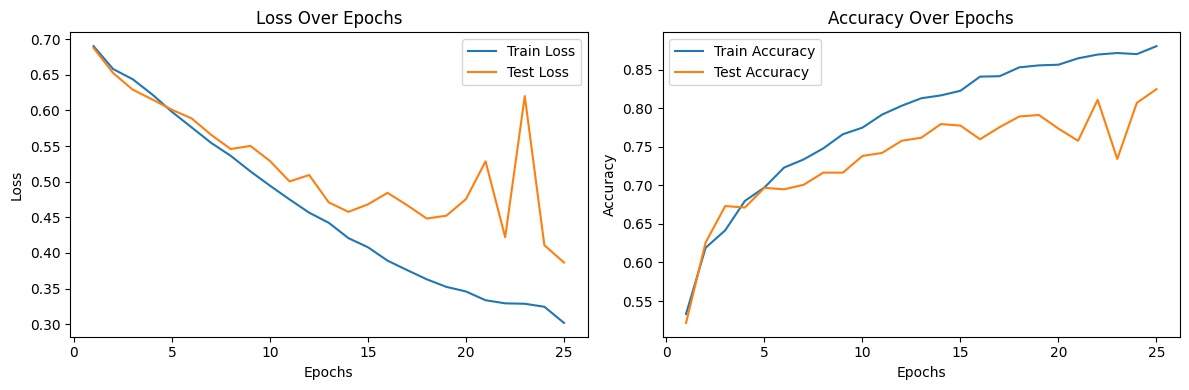

Accuracy finale : 0.8248031496062992


In [23]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score


device = torch.device('cuda')

num_epochs = 25
model = AlexNetUnbiased(num_classes=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
#Apprentissage pour un modèle non biaisé
optimizer = optim.Adam(model.parameters(), lr=1e-5,weight_decay=5e-1)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    all_preds = []
    all_labels=[]
    model.train()
    for i, batch in enumerate(tqdm(trainloader,desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, label = batch
        inputs, label = inputs.to(device).float(), label.to(device)

        #Apprentissage
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)
   
        running_loss += loss.item()
        #Calcul de l'accuracy      
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        loss.backward()
        optimizer.step()
 
    # Stockez la perte d'entraînement moyenne à cette époque
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(accuracy_score(all_labels, all_preds))  

    # Calculez la perte de test à cette époque
    running_loss = 0.0
    all_preds = []
    all_labels=[]

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            inputs, label = batch
            inputs, label = inputs.to(device).float(), label.to(device)  

            outputs = model(inputs)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Stockez la perte de test moyenne à cette époque
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f"Accuracy de train : {train_accuracies[-1]}")
    print(f"Accuracy de test : {test_accuracies[-1]}")
print('Entraînement terminé')

#Affichage des résultats
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


print(f"Accuracy finale : {test_accuracies[-1]}")
torch.save(model.state_dict(), 'Alex_Net_unbiased.pth')

In [15]:
from sklearn.metrics import accuracy_score

In [17]:
def DI(y_pred,list_S): #On définit la mesure comme indiqué dans le sujet
    count_zero = list_S.count(0) #compte le nb de S à 0
    count_non_zero = len(list_S) - count_zero #compte le nb de S à 1

    indices = [i for i, (y_value, list_s_value) in enumerate(zip(y_pred, list_S)) if y_value == 1 and list_s_value == 0]
    count_10 = len(indices) #compte le nb de S à 0 et de y à 1

    indices = [i for i, (y_value, list_s_value) in enumerate(zip(y_pred, list_S)) if y_value == 1 and list_s_value == 1]
    count_11 = len(indices) #compte le nb de S à 1 et de y à 1

    return (count_10/count_zero)/(count_11/count_non_zero)

In [53]:
import torch.nn.functional as F
y_pred = []
list_S=[]
labels=[]
device = torch.device('cuda')

#On crée le dataset
test_set=BiasedDataset("train.csv","biased/test",p0=0.5,p1=0.5,test=True)
test_loader=Data.DataLoader(test_set,batch_size=1,shuffle=False)

#On charge le modèle
model=AlexNetBiased(num_classes=2)
model.load_state_dict(torch.load('Alex_Net_biased.pth'))
model.to(device)

model.eval()

#On fait une prédiction pour tout l'échantillon
with torch.no_grad():
    for batch in test_loader:
        img , label, s = batch

        labels.append(label)
        list_S.append(s)    

        img=img.to(device)
        y = model(img)
        y = F.softmax(y,dim=1)

        y_argmax = torch.argmax(y).item()
        y_pred.append((y_argmax))
labels = [int(label.item()) for label in labels]
list_S=[int(s.item()) for s in list_S]
#On affiche l'accuracy
print(f"accuracy biased {accuracy_score(y_pred,labels)}")
#On affiche le score DI
print(f"DI : {DI(y_pred,list_S)}")


accuracy biased 0.47435897435897434
DI : 0.0


In [38]:
import torch.nn.functional as F
y_pred = []
list_S=[]
labels=[]
device = torch.device('cuda')

#On crée le dataset

test_set=BiasedDataset("train.csv","biased/test",p0=0.5,p1=0.5,test=True)
test_loader=Data.DataLoader(test_set,batch_size=1,shuffle=False)

#On charge le modèle
model=AlexNetBiased(num_classes=2)
model.load_state_dict(torch.load('Alex_Net_less_biased.pth'))
model.to(device)


model.eval()

#On fait une prédiction pour tout l'échantillon
with torch.no_grad():
    for batch in test_loader:
        img , label, s = batch

        labels.append(label)
        list_S.append(s)    

        img=img.to(device)
        y = model(img)
        y = F.softmax(y,dim=1)

        y_argmax = torch.argmax(y).item()
        y_pred.append((y_argmax))
labels = [int(label.item()) for label in labels]
list_S=[int(s.item()) for s in list_S]
#On affiche l'accuracy
print(f"accuracy biased {accuracy_score(y_pred,labels)}")
#On affiche le score DI
print(f"DI : {DI(y_pred,list_S)}")


accuracy biased 0.7008547008547008
DI : 0.862654716175843


In [43]:
y_pred = []
labels=[]
device = torch.device('cuda')

train_size = 3492
test_size = len(df) - train_size

df=ImageDataset("train.csv","train/train")

#On crée le dataset de test 
test_dataset = Data.Subset(df, range(train_size, train_size + test_size))
test_loader = Data.DataLoader(test_dataset, batch_size=1, shuffle=False)

#On charge le modèle
model=AlexNetUnbiased(num_classes=2)
model.load_state_dict(torch.load('Alex_Net_unbiased.pth'))
model.to(device)


model.eval()
#On fait des prédictions pour tout l'échantillon
with torch.no_grad():
    for batch in test_loader:
        img , label = batch
        labels.append(label)
        list_S.append(s)    

        img=img.to(device)
        y = model(img)
        y = F.softmax(y,dim=1)

        y_argmax = torch.argmax(y).item()
        y_pred.append((y_argmax))

labels = [int(label.item()) for label in labels]
#On affiche l'accuracy
print(accuracy_score(y_pred,labels))


0.8248031496062992
